In [1]:
import torch
from torch import nn
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import json
import models
import utils

In [2]:
with open('configuration.json') as file:
    configuration = json.load(file)

IMG_HEIGHT = configuration["image"]["heigth"]
IMG_WIDTH = configuration["image"]["width"]
IMG_CHANNELS = configuration["image"]["channels"]

device = utils.select_device()
X, Y = utils.load_images()
train_loader, validation_loader, test_loader = utils.create_loader(X, Y)

GPU disponible
imagenes


100%|██████████| 2680/2680 [00:06<00:00, 395.36it/s]


mascaras


100%|██████████| 2680/2680 [00:04<00:00, 644.76it/s]


In [ ]:
model = models.UNet()
aux = models.Auto()
aux.load_state_dict(torch.load("./models/auto.pth"))
model.encoder.load_state_dict(aux.encoder.state_dict())

for param in model.encoder.parameters():
    param.requires_grad = False

model.to(device)

# Definimos los hiperparámetros
n_epochs = 1000
lr=0.0001
patience = 20 # (vamos a usar early stopping, así que definimos un valor de paciencia)

# Definimos la función de pérdida (error cuadrático medio)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

C:\Users\mauri\AppData\Local\Temp\ipykernel_6524\1917608417.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  aux.load_state_dict(torch.load("./models/auto1.pth"))


In [4]:
# Definimos las funciones de entrenamiento y evaluación

def train(model,loader):
    total_loss = 0.0
    for data in loader:
        model.train()
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device).unsqueeze(1)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
    total_loss/= len(loader.dataset)
    return total_loss 


def test(model,loader):
    model.eval()
    total_loss = 0.0
    for data in loader:
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device).unsqueeze(1)
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        total_loss += loss.item() * inputs.size(0)
    total_loss/= len(loader.dataset)
    return total_loss

In [5]:
# Entrenamos con early stopping

# Valores iniciales para el early stopping
best_val_loss = 10000.0
best_train_loss = 10000.0
j = 0
epoch = 0
selected_model_state_dict = model.state_dict()

start = time.time()
i_time = time.time()

while ((epoch < n_epochs) and (j < patience)):
    train_loss = train(model, train_loader)
    validation_loss = test(model, validation_loader)
    
    if epoch%10 == 0:
        i_elapsed = time.time()-i_time

        print('Epoca: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Train loss: {:.4f}".format(train_loss), ", Validation loss: {:.4f}".format(validation_loss), ", best: {:.4f}".format(min(best_val_loss, validation_loss)), f", Elapsed: {int((i_elapsed // 60) % 60)} minutos, {int(i_elapsed % 60)} segundos")
        i_time = time.time()
        
    if (validation_loss <= best_val_loss):
        best_epoch = epoch
        best_train_loss = train_loss
        best_val_loss = validation_loss
        selected_model_state_dict = model.state_dict()
        j = 0
    else:
        j += 1

    epoch += 1
        
print('La mejor Epoca fue {:03d}, Train loss: {:.4f}, Validation loss: {:.4f}'.format(
              best_epoch, best_train_loss, best_val_loss))
end = time.time()
elapsed = end-start
print(f"Tiempo de ejecución: {int(elapsed // 3600)} horas, {int((elapsed // 60) % 60)} minutos, {int(elapsed % 60)} segundos")

# Nos quedamos con el modelo con mejor valor de validación  
model.load_state_dict(selected_model_state_dict)

Epoca: 0/1000............. Train loss: 0.6373 , Validation loss: 0.5881
Epoca: 10/1000............. Train loss: 0.1234 , Validation loss: 0.1170
Epoca: 20/1000............. Train loss: 0.1016 , Validation loss: 0.0966
Epoca: 30/1000............. Train loss: 0.0916 , Validation loss: 0.0899
Epoca: 40/1000............. Train loss: 0.0863 , Validation loss: 0.0841
Epoca: 50/1000............. Train loss: 0.0802 , Validation loss: 0.0778
Epoca: 60/1000............. Train loss: 0.0770 , Validation loss: 0.0760
Epoca: 70/1000............. Train loss: 0.0716 , Validation loss: 0.1261
Epoca: 80/1000............. Train loss: 0.0707 , Validation loss: 0.0696
Epoca: 90/1000............. Train loss: 0.0679 , Validation loss: 0.0683
Epoca: 100/1000............. Train loss: 0.0657 , Validation loss: 0.0730
Epoca: 110/1000............. Train loss: 0.0634 , Validation loss: 0.0667
Epoca: 120/1000............. Train loss: 0.0632 , Validation loss: 0.0669
Epoca: 130/1000............. Train loss: 0.0619 ,

<All keys matched successfully>

In [6]:
torch.save(model.state_dict(), "./models/transfer.pth")

In [7]:
model.load_state_dict(torch.load("./models/transfer.pth"))

C:\Users\mauri\AppData\Local\Temp\ipykernel_6524\3057224840.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/transfer.pth"))


<All keys matched successfully>

In [8]:
model.eval()
idx = 12
input = torch.tensor(X[idx], dtype=torch.float32).unsqueeze(0).to(device)
mask = Y[idx]
with torch.no_grad():
    output = model(input)

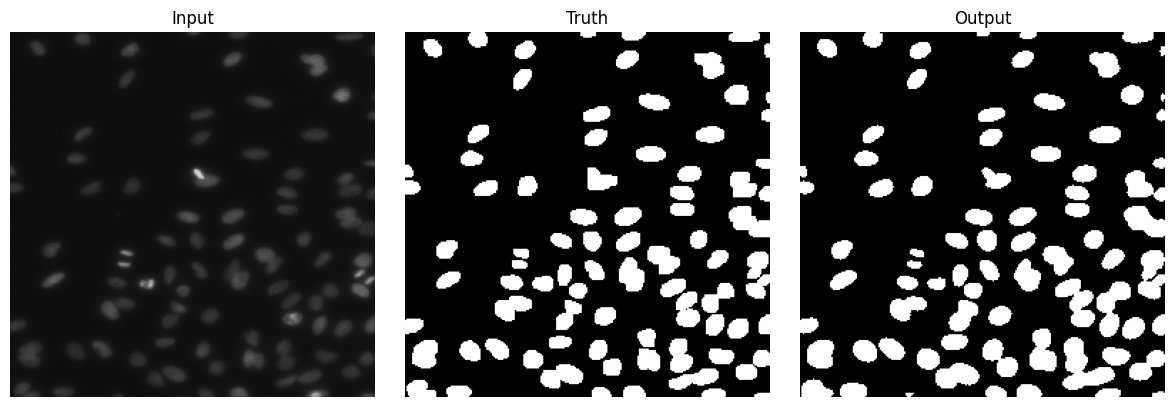

In [9]:
input_image = input.squeeze().permute(1, 2, 0).cpu().numpy()/255
mask_image = mask
output = (output > 0.5)
output_image = output.squeeze().cpu().numpy()/255

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(input_image)
axs[0].set_title("Input")

axs[1].imshow(mask_image, cmap = "grey")  # Si tienes ground truth
axs[1].set_title("Truth")

axs[2].imshow(output_image, cmap = "grey")  # Si tienes ground truth
axs[2].set_title("Output")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
a, b = utils.test_similarity(model, zip(X, Y))

2680it [00:11, 230.42it/s]

Dice: 0.9098391371936286
Jaccard: 0.8402608313065348
